In [121]:
# Import necessary libraries
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

## Vaguely checkout data

In [122]:
#2d input data for neural network algorithms
train_data = xr.open_mfdataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/ML_testing/3yr_norm_anom/ds_train')
validate_data = xr.open_mfdataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/ML_testing/3yr_norm_anom/ds_validate')
test_data = xr.open_mfdataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/ML_testing/3yr_norm_anom/ds_test')


In [123]:
train_ars = np.array(train_data.label_1d_AR)
test_ars = np.array(test_data.label_1d_AR)
validate_ars = np.array(validate_data.label_1d_AR)

In [124]:
print(
'Num ARs in training: '+str(len(train_ars[train_ars==1]))+' out of '+str(len(train_ars))+' timesteps'+ 
'\nNum ARs in testing: '+str(len(test_ars[test_ars==1]))+' out of '+str(len(test_ars))+' timesteps'+   
'\nNum ARs in validating: '+str(len(validate_ars[validate_ars==1]))+' out of '+str(len(validate_ars))+' timesteps')

Num ARs in training: 503 out of 3068 timesteps
Num ARs in testing: 96 out of 658 timesteps
Num ARs in validating: 105 out of 658 timesteps


In [125]:
print(
'% ARs in training: '+str(np.round(100*len(train_ars[train_ars==1])/len(train_ars)))+ 
'\n% ARs in testing: '+str(np.round(100*len(test_ars[test_ars==1])/len(test_ars)))+   
'\n% ARs in validating: '+str(np.round(100*len(validate_ars[validate_ars==1])/len(validate_ars))))

% ARs in training: 16.0
% ARs in testing: 15.0
% ARs in validating: 16.0


# Use data made for 1d machine learning, created in Make_test_data.ipynb

In [142]:

df_t = pd.read_csv('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/ML_testing/3yr_norm_anom/tradML_ds_train', index_col = 0)
df_v = pd.read_csv('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/ML_testing/3yr_norm_anom/tradML_ds_validate', index_col = 0)


In [159]:
np.argwhere(np.array(df_t.isna().any(axis=1)))

array([[1020]])

In [170]:
df_t.iloc[1020,12:18] = 0

# Re-train using traditional ML 

From notebook /projects/reba1583/Research3/WAF_ML_Tutorial_Part2/jupyter_notebooks/Notebook03_Retrain_Traditional_ML.ipynb

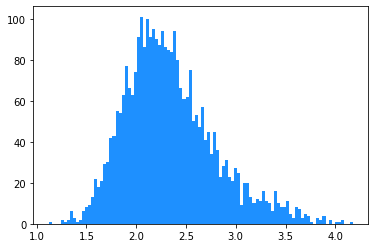

In [141]:
plt.hist(df_t.q_100_H,bins=100,color='dodgerblue');

# Split into X and Y

In [171]:
# Here the y is the classification label - O for no landfalling AR and 1 for landfalling AR
X_t = df_t.to_numpy()[:,:54]
y_t = df_t.to_numpy()[:,54]
X_v = df_v.to_numpy()[:,:54]
y_v = df_v.to_numpy()[:,54]

# Train some models!

In [172]:
#load ML code from sklearn
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB

In [173]:
#initialize models in a list that we can loop over 
model_list = [LogisticRegression(),GaussianNB(),DecisionTreeClassifier(),RandomForestClassifier(),GradientBoostingClassifier(),LinearSVC(dual=False)]

print(model_list)

[LogisticRegression(), GaussianNB(), DecisionTreeClassifier(), RandomForestClassifier(), GradientBoostingClassifier(), LinearSVC(dual=False)]


In [174]:
#Import a progress bar so we know how long it is taking
import tqdm

#loop over models and train with the same training data
for model in tqdm.tqdm(model_list):
    model.fit(X_t,y_t)

  0%|          | 0/6 [00:00<?, ?it/s]/home/reba1583/.local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


# Evaluate the models

ZeroDivisionError: 0.0 cannot be raised to a negative power

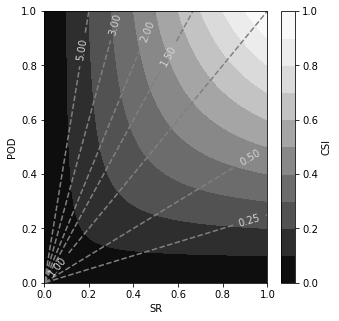

In [179]:
#import some helper functions from our other directory.
import sys
sys.path.insert(1, '/projects/reba1583/Research3/WAF_ML_Tutorial_Part2/scripts')

#load contingency_table func
from gewitter_functions import get_contingency_table,make_performance_diagram_axis,get_acc,get_pod,get_sr,csi_from_sr_and_pod

#make axis to plot on 
ax = make_performance_diagram_axis()

#make list of colors so each method shows up as a different color
colors=['b','b','b','b','b','b']
legend_labels = ['LgR','NB','DT','RF','GBT','SVM']
#list of different marker types, check the documentation here for the full list: https://matplotlib.org/stable/api/markers_api.html 
markers = ['o','^','>','8','s','h']

#loop over all trained models 
for idx,model in enumerate(model_list):
    #get predictions 
    yhat = model.predict(X_v)
    #the contingency table calculator expects y_true,y_pred
    cont_table = get_contingency_table(y_v,yhat)
    
    #get metrics
    accuracy = get_acc(cont_table)
    pod = get_pod(cont_table)
    sr = get_sr(cont_table)
    csi = csi_from_sr_and_pod(sr,pod)
    
    #plot the marker 
    ax.plot(sr,pod,markers[idx],color=colors[idx],markerfacecolor='w',label=legend_labels[idx])
    
    #print some stats so we dont have to read it off the plot
    print('{} accuracy: {}%'.format(legend_labels[idx],np.round(accuracy,0)))
    print('{} CSI: {}'.format(legend_labels[idx],np.round(csi,2)))
    
#draw legend 
ax.legend()

plt.tight_layout()

LgR:  AUC: 0.52
NB:  AUC: 0.53
DT:  AUC: 0.55
RF:  AUC: 0.54
GBT:  AUC: 0.54


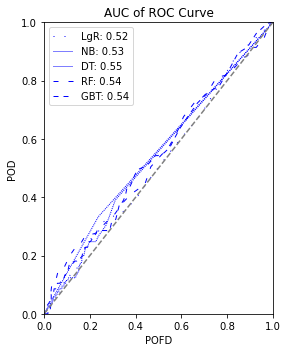

In [181]:
#load contingency_table func
from gewitter_functions import get_points_in_roc_curve,get_area_under_roc_curve

#make figure
fig = plt.figure(figsize=(4.1,5))
#set facecolor to white so you can copy/paste the image somewhere 
fig.set_facecolor('w')

#make list of colors so each method shows up as a different color
colors=['b','b','b','b','b','b']
legend_labels = ['LgR: ','NB: ','DT: ','RF: ','GBT: ','SVM: ']

#this is a fancy way of encoding line styles, dont worry, I do NOT know these, I googled. 
line_styles = [(0, (1, 10)),(0, (1, 1)),(0, (1, 1)),(0, (5, 10)),(0, (5, 5)),(0, (5, 1))]
    
ax = plt.gca()

#loop over all trained models 
for idx,model in enumerate(model_list[:-1]):
    #get predictions 
    yhat_proba = model.predict_proba(X_v)
    
    #lets just focus on the output from class 1 (note, the sum of these two columns should be 1)
    y_preds = yhat_proba[:,1]
    
    #get the roc curve
    pofds, pods = get_points_in_roc_curve(forecast_probabilities=y_preds, observed_labels=y_v, threshold_arg=np.linspace(0,1,100))
    
    #get AUC 
    auc = get_area_under_roc_curve(pofds,pods)
    
    #plot the lines 
    ax.plot(pofds,pods,ls=line_styles[idx],color=colors[idx],label=legend_labels[idx] + str(np.round(auc,2)),lw=1)
    
    print('{} AUC: {}'.format(legend_labels[idx],np.round(auc,2)))
    
#draw legend 
ax.legend()

#set some limits
ax.set_xlim([0,1])
ax.set_ylim([0,1])

#set the no-skill line
ax.plot([0,1],[0,1],'--',color='Grey')

#label things
ax.set_title("AUC of ROC Curve")
ax.set_xlabel('POFD')
ax.set_ylabel('POD')

plt.tight_layout()

# Train some regression models

In [183]:
y_t = df_t.to_numpy()[:,55]
y_v = df_v.to_numpy()[:,55]

In [184]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR

#initialize
model_list = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor(), GradientBoostingRegressor(), LinearSVR()]

print(model_list)

[LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor(), GradientBoostingRegressor(), LinearSVR()]


In [185]:
for model in tqdm.tqdm(model_list):
    model.fit(X_t,y_t)

100%|██████████| 5/5 [00:15<00:00,  3.17s/it]


n_samples= --
n_samples= --
n_samples= --
n_samples= --
n_samples= --


/projects/reba1583/software/anaconda/envs/research/lib/python3.7/site-packages/ipykernel_launcher.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


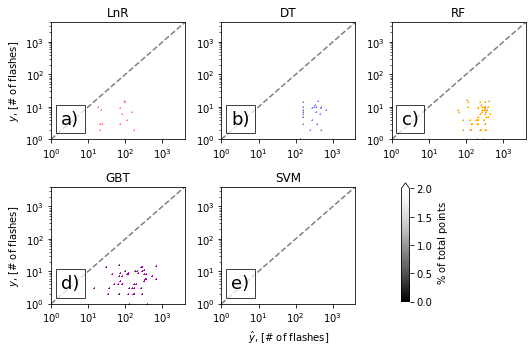

In [187]:
import matplotlib
from aux_functions import boxbin,make_colorbar
#make figure with 2 rows and 3 columns with size 7.5" by 5"
fig,axes = plt.subplots(2,3,figsize=(7.5,5))
#set facecolor to white so we can copy paste it if you want to somewhere else
fig.set_facecolor('w')

#the number of bins for the boxbin method 
n = 33
#the bins we want in x and y 
xbins = np.logspace(0,3.5,n)
ybins = np.logspace(0,3.5,n)

#colors i like 
r = [255/255,127/255,127/255]
b = [126/255,131/255,248/255]

#labels
labels= ['LnR','DT','RF','GBT','SVM']
#color list, one for each model 
colors= [r,b,'orange','purple','dimgrey']
#colormaps to match the colors in 'theme'
cmaps=['Reds_r','Blues_r','Oranges_r','Purples_r','Greys_r']

#force ticks to show up where i want them 
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=(0.1,0.2,0.4,0.6,0.8,1,2,4,6,8,10 )) 

#axes is shape [2,3], it is easier to loop if we flatten this, which is what ravel does 
axes = axes.ravel()

#some parameters to make it pretty 
c_scale = 0.575
fs3 = 11
fs4 = 18
props = dict(boxstyle='square', facecolor='White', alpha=0.75)
annotate_list = ['a)','b)','c)','d)','e)',]

#draw a new axis for a new colorbar to go on 
ax_cbar = fig.add_axes([0.75, 0.15, 0.015,0.33])
#draw that colorbar 
cbar = make_colorbar(ax_cbar,0,2,plt.cm.Greys_r)
#label that colorbar 
cbar.set_label('$\%$ of total points')

#loop over axes and draw scatters 
for i,ax in enumerate(axes):
    #we have 1 too many subplots, so turn off the last one [5]
    if i==5:
        ax.axis('off')
        break
    #make axes log-log     
    ax.semilogy()
    ax.semilogx()
    
    #grab model
    model = model_list[i]
    #get predicitions 
    yhat = model.predict(X_v)
    #make scatter plot 
    ax.scatter(yhat,y_v,color=colors[i],s=1,marker='+')
    
    #box and bin up data to show density of points 
    ax,cbar,C = boxbin(yhat,y_v,xbins,ybins,ax=ax,mincnt=10,normed=True,cmap=cmaps[i],vmin=0,vmax=2,cbar=False)
    
    #set some axis limits and ticks 
    ax.set_xlim([1,4000])
    ax.set_xticks([1,10,100,1000])
    ax.set_yticks([1,10,100,1000])
    ax.set_ylim([1,4000])
    
    #add diaganol line 
    ax.plot([1,4000],[1,4000],'--k',alpha=0.5)
    
    #add a subplot label 
    ax.text(0.075, 0.25, annotate_list[i], transform=ax.transAxes,fontsize=fs4,
        verticalalignment='top', bbox=props)
    
    #only label certain axes x-y axis to save space 
    if (i == 0) or (i==3):
        ax.set_ylabel('$y$, [# of flashes]')
    if i==4:
        ax.set_xlabel(r'$\hat{y}$, [# of flashes]')
        
    #label each subplot title as the method used 
    ax.set_title(labels[i])
    
plt.tight_layout()

In [188]:
from gewitter_functions import get_mae,get_rmse,get_bias,get_r2

#loop over all trained models 
for idx,model in enumerate(model_list):
    #get predictions 
    yhat = model.predict(X_v)
    
    mae = get_mae(y_v,yhat)
    rmse = get_rmse(y_v,yhat)
    bias = get_bias(y_v,yhat)
    r2 = get_r2(y_v,yhat)

    #print them out so we can see them 
    print('Method: {} .. MAE:{} flashes, RMSE:{} flashes, Bias:{} flashes, Rsquared:{}'.format(labels[idx],np.round(mae,2),np.round(rmse,2),np.round(bias,2),np.round(r2,2)))

Method: LnR .. MAE:100.0 flashes, RMSE:122.51 flashes, Bias:67.62 flashes, Rsquared:-3776.66
Method: DT .. MAE:176.93 flashes, RMSE:283.41 flashes, Bias:-176.49 flashes, Rsquared:-20216.66
Method: RF .. MAE:193.55 flashes, RMSE:216.92 flashes, Bias:-193.55 flashes, Rsquared:-11843.37
Method: GBT .. MAE:138.06 flashes, RMSE:200.19 flashes, Bias:-137.05 flashes, Rsquared:-10086.74
Method: SVM .. MAE:0.5 flashes, RMSE:2.05 flashes, Bias:0.48 flashes, Rsquared:-0.06


In [189]:
from gewitter_functions import get_mae,get_rmse,get_bias,get_r2

#loop over all trained models 
for idx,model in enumerate(model_list):
    #get predictions 
    yhat = model.predict(X_v)
    
    mae = get_mae(y_v,yhat)
    rmse = get_rmse(y_v,yhat)
    bias = get_bias(y_v,yhat)
    r2 = get_r2(y_v,yhat)

    #print them out so we can see them 
    print('Method: {} .. MAE:{} flashes, RMSE:{} flashes, Bias:{} flashes, Rsquared:{}'.format(labels[idx],np.round(mae,2),np.round(rmse,2),np.round(bias,2),np.round(r2,2)))

Method: LnR .. MAE:100.0 flashes, RMSE:122.51 flashes, Bias:67.62 flashes, Rsquared:-3776.66
Method: DT .. MAE:176.93 flashes, RMSE:283.41 flashes, Bias:-176.49 flashes, Rsquared:-20216.66
Method: RF .. MAE:193.55 flashes, RMSE:216.92 flashes, Bias:-193.55 flashes, Rsquared:-11843.37
Method: GBT .. MAE:138.06 flashes, RMSE:200.19 flashes, Bias:-137.05 flashes, Rsquared:-10086.74
Method: SVM .. MAE:0.5 flashes, RMSE:2.05 flashes, Bias:0.48 flashes, Rsquared:-0.06


In [193]:
#some annotation helpers
import matplotlib.patheffects as path_effects
pe = [path_effects.withStroke(linewidth=2,
                             foreground="k")]
pe2 = [path_effects.withStroke(linewidth=2,
                             foreground="w")]
#make a 2 row, 2 column figure of size 5" by 5"
fig,axes = plt.subplots(2,2,figsize=(10,10))
#set facecolor to white so we can copy/paste it whereever
fig.set_facecolor('w')

#list of labels for the x-axis 
labels= ['LnR','DT','RF','GBT','SVM']

#loop over all trained models 
for i,model in enumerate(model_list):
    #get predictions 
    yhat = model.predict(X_v)
    mae = get_mae(y_v,yhat)
    rmse = get_rmse(y_v,yhat)
    bias = get_bias(y_v,yhat)
    r2 = get_r2(y_v,yhat)
    
    ############### subplot 0,0: Bias ########################
    ax = axes[0,0]
    #put a bar at position i (from our loop)
    ax.bar(i,bias,width=0.95,color=colors[i])
    #make the annotation so we can see the numerical data on the plot 
    annotate = str(int(np.round(bias))).rjust(3, ' ')
    ax.text(i-0.4,bias+5,annotate,color=colors[i],path_effects=pe2)
    ##########################################################

    ####### subplot 0,1: Mean Absolute Error #################
    ax = axes[0,1]
    #put a bar at position i (from our loop)
    ax.bar(i,mae,width=0.95,color=colors[i])
    #make the annotation so we can see the numerical data on the plot 
    annotate = str(int(np.round(mae))).rjust(3, ' ')
    ax.text(i-0.4,mae+5,annotate,color=colors[i],path_effects=pe2)
    ##########################################################
    
    ####### subplot 1,0: Root Mean Squared Error #############
    ax = axes[1,0]
    ax.bar(i,rmse,width=0.95,color=colors[i])
    annotate = str(int(np.round(rmse))).rjust(3, ' ')
    ax.text(i-0.4,rmse+5,annotate,color=colors[i],path_effects=pe2)
    ##########################################################
    
    ####### subplot 1,1: Rsquared ###########################
    ax = axes[1,1]
    ax.bar(i,r2,width=0.95,color=colors[i])
    annotate = str(np.round(r2,2)).ljust(4, '0')
    ax.text(i-0.5,r2+0.05,annotate,color=colors[i],path_effects=pe2)
    ##########################################################
    

    

#cosmetic things: 
ax = axes[0,0]
ax.xaxis.set_ticks(np.arange(0,5))
ax.xaxis.set_ticklabels(labels,rotation=45)
ax.set_ylim([-130,130])
ax.set_title("Bias")
ax.text(0.075, 0.25, annotate_list[0], transform=ax.transAxes,fontsize=fs4,
verticalalignment='top', bbox=props)

ax = axes[0,1]
ax.set_ylim([0,200])
ax.xaxis.set_ticks(np.arange(0,5))
ax.xaxis.set_ticklabels(labels,rotation=45)
ax.set_title("Mean Abs. Error")
ax.text(0.075, 0.25, annotate_list[1], transform=ax.transAxes,fontsize=fs4,
verticalalignment='top', bbox=props)

ax = axes[1,0]
ax.set_ylim([0,300])
ax.xaxis.set_ticks(np.arange(0,5))
ax.xaxis.set_ticklabels(labels,rotation=45)
ax.set_title("Root Mean Sq. Error")
ax.text(0.075, 0.25, annotate_list[2], transform=ax.transAxes,fontsize=fs4,
verticalalignment='top', bbox=props)

ax = axes[1,1]
ax.set_ylim([-1,1])
ax.xaxis.set_ticks(np.arange(0,5))
ax.xaxis.set_ticklabels(labels,rotation=45)
ax.set_title("$R^{2}$")
ax.text(0.075, 0.25, annotate_list[3], transform=ax.transAxes,fontsize=fs4,
verticalalignment='top', bbox=props)
    
# plt.tight_layout()

Text(0.075, 0.25, 'd)')

ValueError: Image size of 606x2498122 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 720x720 with 4 Axes>